In [1]:
#import rbsa
import pandas as pd
import numpy as np
import os
import datetime
from calendar import monthrange
import matplotlib.pyplot as plt

In [2]:
"""Load electrification
"""

import sys
import pandas as pd

def find_csvfile(name):
    return str(sys.modules[__name__].__file__).replace(f"/loads.py",f"/{name}.csv")


electrification_index = ["location"]
electrification_data = ["heat_pump","other_electric_heat","cooling","water_heating","cooking"]
electrification_attributes = ["city","region","building_type"]
def load_electrification (
        select={},
        index="location",
        columns=["city","region","building_type","heat_pump",
            "other_electric_heat","cooling","water_heating","cooking"],
        convert=pd.DataFrame,
        version='latest'
        ):

    data = pd.read_csv('C:/Users/Palash Goiporia/GISMO_files/load_composition_analysis/src/electrification/loads-latest.csv')
    for key,value in select.items():
        data = data[data[key]==value]
    return convert(data.set_index(index)[columns])

locations = pd.read_csv("rbsa_locations.csv")
locations['postcode'] = np.array(locations['postcode'])//100
siteid_zip = {}
for i in range(locations.shape[0]):
    siteid_zip[str(locations.iloc[i][0])] = locations.iloc[i][3]


In [3]:
#pd.set_option('display.max_rows', None)
electrification = load_electrification()
electrification

,city,region,building_type,heat_pump,other_electric_heat,cooling,water_heating,cooking
location,,,,,,,,
ABI,Abilene TX,West South Central,commercial,0.10,0.30,0.81,0.47,0.25
ABI,Abilene TX,West South Central,residential,0.08,0.45,0.95,0.58,0.71
ALB,Albany NY,Middle Atlantic,commercial,0.09,0.06,0.89,0.41,0.31
ALB,Albany NY,Middle Atlantic,residential,0.03,0.11,0.88,0.31,0.43
AMA,Amarillo TX,West South Central,commercial,0.10,0.30,0.81,0.47,0.25
...,...,...,...,...,...,...,...,...
YYC,Calgary AB,Canada,residential,0.00,0.08,0.00,0.00,0.00
YYZ,Toronto ON,Canada,commercial,0.00,0.12,0.00,0.00,0.00
YYZ,Toronto ON,Canada,residential,0.00,0.15,0.00,0.00,0.00


In [4]:
import feeder_composition as fc
x = fc.rbsa_file_reader('weekday', electrification)

siteid 13956 processed
siteid 13445 processed
siteid 10887 processed
siteid 13970 processed
siteid 10388 processed
siteid 13336 processed
siteid 11418 processed
siteid 12063 processed
siteid 13222 processed
siteid 12975 processed
siteid 13880 processed
siteid 10040 processed
siteid 13248 processed
siteid 12994 processed
siteid 13895 processed
siteid 13261 processed
siteid 13903 processed
siteid 13400 processed
siteid 13912 processed
siteid 12507 processed
siteid 13019 processed
siteid 13554 processed
siteid 13691 processed
siteid 13948 processed
siteid 11775 processed
siteid 14211 processed
siteid 14222 processed
siteid 13974 processed
siteid 13975 processed
siteid 14102 processed
siteid 14329 processed
siteid 14508 processed
siteid 14000 processed
siteid 14264 processed
siteid 14140 processed
siteid 14012 processed
siteid 14015 processed
siteid 14273 processed
siteid 14277 processed
siteid 14150 processed
siteid 14153 processed
siteid 14284 processed
siteid 14285 processed
siteid 1454

In [5]:
rbsa_data_weekday = x
rbsa_enduses = None
for col in rbsa_data_weekday[1].keys():
    try:
        rbsa_enduses = pd.merge(rbsa_data_weekday[1][col].drop(columns = ['temp']), rbsa_enduses, left_index = True, right_index = True)
    except:
        rbsa_enduses = rbsa_data_weekday[1][col]
rbsa_enduses.to_csv('rbsa_enduses.csv')

In [6]:
import load_composition as lc
start = datetime.datetime.now()
dt = lambda ts: datetime.datetime.strptime(ts,"%Y-%m-%d %H:%M:%S")
rbsa_enduses = pd.read_csv('rbsa_enduses.csv')
rbsa_enduses['index'] = [dt(t) for t in rbsa_enduses.rename(columns = {'Unnamed: 0': 'Date'}).set_index('Date').index.values]
rbsa_enduses = rbsa_enduses.set_index('index').drop(columns = ['Unnamed: 0'])
sens = lc.sensitivity_models(buildings = None, data = rbsa_enduses, weekday = 'weekday', build_class = 'residential')
print((datetime.datetime.now() - start).total_seconds())

2.35158


In [7]:
import feeder_composition as fc
start = datetime.datetime.now()
old = 0
commercial_composite_enduses = {}
#building_type_dict = {}
for xls in sorted(os.listdir('C:/Users/Palash Goiporia/GISMO_files/ceus_data/xls/')):
    if xls.endswith('.xls'):
        filename = xls.split('.')[0]
        zone, building_type = filename.split('_')[0], filename.split('_')[1]
        df = fc.composite_enduse(filename, electrification)
        if zone != old:
            building_type_dict = {}

        building_type_dict[building_type] = df
        try:
            commercial_composite_enduses[zone].append(building_type_dict)
        except:
            commercial_composite_enduses[zone] = building_type_dict
        old = zone
        print(filename)
print((datetime.datetime.now() - start).total_seconds())

FCZ01_AOFF
FCZ01_AWHS
FCZ01_COLL
FCZ01_GROC
FCZ01_HLTH
FCZ01_LODG
FCZ01_LOFF
FCZ01_MISC
FCZ01_REFW
FCZ01_REST
FCZ01_RETL
FCZ01_SCHL
FCZ01_SOFF
FCZ02_AOFF
FCZ02_AWHS
FCZ02_COLL
FCZ02_GROC
FCZ02_HLTH
FCZ02_LODG
FCZ02_LOFF
FCZ02_MISC
FCZ02_REFW
FCZ02_REST
FCZ02_RETL
FCZ02_SCHL
FCZ02_SOFF
FCZ02_WRHS
FCZ03_AOFF
FCZ03_AWHS
FCZ03_COLL
FCZ03_GROC
FCZ03_HLTH
FCZ03_LODG
FCZ03_LOFF
FCZ03_MISC
FCZ03_REFW
FCZ03_REST
FCZ03_RETL
FCZ03_SCHL
FCZ03_SOFF
FCZ03_WRHS
FCZ04_AOFF
FCZ04_AWHS
FCZ04_COLL
FCZ04_GROC
FCZ04_HLTH
FCZ04_LODG
FCZ04_LOFF
FCZ04_MISC
FCZ04_REFW
FCZ04_REST
FCZ04_RETL
FCZ04_SCHL
FCZ04_SOFF
FCZ04_WRHS
FCZ05_AOFF
FCZ05_AWHS
FCZ05_COLL
FCZ05_GROC
FCZ05_HLTH
FCZ05_LODG
FCZ05_LOFF
FCZ05_MISC
FCZ05_REFW
FCZ05_REST
FCZ05_RETL
FCZ05_SCHL
FCZ05_SOFF
FCZ05_WRHS
FCZ06_AOFF
FCZ06_AWHS
FCZ06_COLL
FCZ06_GROC
FCZ06_HLTH
FCZ06_LODG
FCZ06_LOFF
FCZ06_MISC
FCZ06_REFW
FCZ06_REST
FCZ06_RETL
FCZ06_SCHL
FCZ06_SOFF
FCZ06_WRHS
FCZ07_AOFF
FCZ07_AWHS
FCZ07_COLL
FCZ07_GROC
FCZ07_HLTH
FCZ07_LODG
FCZ07_LOFF
FCZ07_MISC

In [8]:
area_dict = {}
building_dict = {}
for zone in commercial_composite_enduses.keys():
    for build in commercial_composite_enduses[zone].keys():
        try:
            building_dict[build] = building_dict[build].append(commercial_composite_enduses[zone][build][1])

        except:
            building_dict[build] = commercial_composite_enduses[zone][build][1]

        try:
            for col in commercial_composite_enduses[zone][build][3].keys():
                area_dict[build][col] += commercial_composite_enduses[zone][build][3][col]
        except:
            y = {}
            for col in commercial_composite_enduses[zone][build][3].keys():
                y[col] = commercial_composite_enduses[zone][build][3][col]
            area_dict[build] = y

In [9]:
normed_load = {}
for b in building_dict.keys():
    temp = building_dict[b].fillna(0).groupby('hour').mean()['drybulb']
    x = []
    for t in building_dict[b]['hour']:
        x.append(pd.Timestamp(t))
    building_dict[b]['hour'] = x
    v = building_dict[b].fillna(0).groupby('hour').sum()
    for col in area_dict[b].keys():
        v[col] = np.array(v[col])/area_dict[b][col]
    v['drybulb'] = temp
    normed_load[b] = v

<ipython-input-9-795df100902c>:10: RuntimeWarning: invalid value encountered in true_divide
  v[col] = np.array(v[col])/area_dict[b][col]


In [10]:
start = datetime.datetime.now()
ceus_tester = lc.sensitivity_models(normed_load.keys(), normed_load, 'weekday', 'commercial')
print((datetime.datetime.now() - start).total_seconds())

AOFF
AWHS
COLL
GROC
HLTH


c:\users\palash goiporia\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\palash goiporia\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\palash goiporia\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


LODG
LOFF
MISC
REFW
REST
RETL
SCHL
SOFF
WRHS
18.450786


1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
0 0
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
0 0
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
500000 0
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
45000 2
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
10000 4
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
50000 20
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
700000 6
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1


C:\Users\Palash Goiporia\GISMO_files\load_composition.py:290: RuntimeWarning: invalid value encountered in less
  p = np.where(np.array(p) < 0, 0, np.array(p))
C:\Users\Palash Goiporia\GISMO_files\load_composition.py:291: RuntimeWarning: invalid value encountered in less
  q = np.where(np.array(q) < 0, 0, np.array(q))
C:\Users\Palash Goiporia\GISMO_files\load_composition.py:292: RuntimeWarning: invalid value encountered in less
  r = np.where(np.array(r) < 0, 0, np.array(r))
C:\Users\Palash Goiporia\GISMO_files\load_composition.py:403: RuntimeWarning: invalid value encountered in greater
  winter.append(np.where(load[0]>0, load[0], 0)*elec)
C:\Users\Palash Goiporia\GISMO_files\load_composition.py:404: RuntimeWarning: invalid value encountered in greater
  spring.append(np.where(load[1]>0, load[1], 0)*elec)
C:\Users\Palash Goiporia\GISMO_files\load_composition.py:405: RuntimeWarning: invalid value encountered in greater
  summer.append(np.where(load[2]>0, load[2], 0)*elec)


10000 1
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
0 0
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
5000 25
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
20000 30
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
100000 0
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
50000 2
1
1
0.33
1
1
1
1
0.9
1
0.39
1
0.08
1
50000 0
1
0.57
1
1
1
1
0.34
0.03
1
1
1
0.17
1
0.92
         0         1         2         3         4         5         6   \
0  0.063072  0.063214  0.062691  0.059994  0.064577  0.067072  0.060161   
1  0.148051  0.148960  0.156486  0.185323  0.150531  0.140213  0.156879   
2  0.007044  0.007148  0.008998  0.019040  0.007607  0.012505  0.013384   
3  0.012303  0.011804  0.011446  0.010316  0.012186  0.013228  0.011779   
4  0.272719  0.276932  0.280275  0.282162  0.284191  0.265421  0.277436   
5  0.162488  0.167443  0.165471  0.163376  0.188322  0.255550  0.195338   
6  0.334323  0.324500  0.314633  0.279788  0.292586  0.246011  0.285024   

         7         8         9   ...        14        15        16        17  \


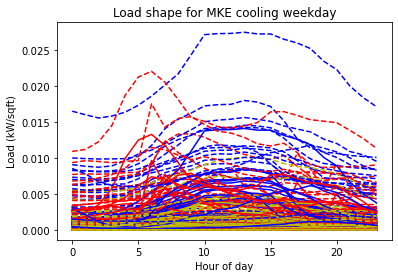

In [13]:
import load_composition as lc
import sensitivity_new as sn
loc = 'MKE'
rbsa_tester = sens
weather = lc.weather_season(loc, 'weekday')
test = lc.comp_enduses(weather = weather, ceus_sens = ceus_tester, rbsa_sens = rbsa_tester, location = loc, feeder = 'commercial', electrification = electrification, debug = True)

#ceus_comp_enduses(weather = weather, ceus_sens = tester, rbsa_sens = sens, location = loc, feeder = 'commercial')